# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from skynet.utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = '../skynet/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = list(range(num_training, num_training + num_validation))
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = list(range(num_training))
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = list(range(num_test))
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **linear/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from skynet.linear.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.374170
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*

By randomly initializing the weights, the prediction results for each class tend to be of equal probability. And there are 10 classes, meaning each has a probability of 1/10.


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from skynet.utils.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.487973 analytic: 1.487973, relative error: 1.303304e-08
numerical: -2.063663 analytic: -2.063663, relative error: 4.233125e-09
numerical: 3.815221 analytic: 3.815221, relative error: 7.272404e-09
numerical: -3.957959 analytic: -3.957959, relative error: 6.813453e-09
numerical: 2.505484 analytic: 2.505483, relative error: 2.030294e-08
numerical: -0.812104 analytic: -0.812104, relative error: 2.174683e-08
numerical: 3.419568 analytic: 3.419568, relative error: 2.192870e-09
numerical: 2.520944 analytic: 2.520944, relative error: 2.077336e-08
numerical: -2.519173 analytic: -2.519173, relative error: 4.118957e-09
numerical: -2.950599 analytic: -2.950599, relative error: 2.142933e-09
numerical: 3.490326 analytic: 3.490326, relative error: 4.314973e-09
numerical: -2.127627 analytic: -2.127627, relative error: 1.989648e-09
numerical: -0.553273 analytic: -0.553273, relative error: 1.326719e-08
numerical: 1.533342 analytic: 1.533342, relative error: 2.110894e-09
numerical: -0.288272

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from skynet.linear.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.374170e+00 computed in 0.077480s
vectorized loss: 2.374170e+00 computed in 0.004260s
Loss difference: 0.000000
Gradient difference: 0.000000


In [6]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from skynet.linear import Softmax
results = {}
best_val = -1
best_softmax = None
# Grid search
# learning_rates = [1e-7, 3e-7, 5e-7, 7e-7, 1e-6, 3e-6]
# regularization_strengths = [1e-5, 5e-5, 1e-4, 3e-4, 5e-4, 1e-3]
learning_rates = np.logspace(-6, -5, 5) # -10, -9, -8, -7, -6, -5, -4
regularization_strengths = np.logspace(-3, 3, 5) # [-4, -3, -2, -1, 1, 2, 3, 4, 5, 6]

# Random search
learning_rates = sorted(10**np.random.uniform(-6, -5, 6))
regularization_strengths = sorted(10**np.random.uniform(-3, 3, 6))


################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for learning_rate in learning_rates:
    for reg in regularization_strengths:
        classifier = Softmax()
        classifier.train(X_train, y_train, 
                         learning_rate=learning_rate, reg=reg, num_iters=1500,
                         batch_size=200, verbose=False)
        y_train_predict = classifier.predict(X_train)
        y_val_predict = classifier.predict(X_val)
        train_accuracy = np.mean(y_train==y_train_predict)
        val_accuracy = np.mean(y_val==y_val_predict)
        results[(learning_rate, reg,)] = (train_accuracy, val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = classifier
        print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
            learning_rate, reg, train_accuracy, val_accuracy))
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 2.427552e-06 reg 1.590637e-02 train accuracy: 0.381286 val accuracy: 0.354000
lr 2.427552e-06 reg 1.626959e+00 train accuracy: 0.381020 val accuracy: 0.347000
lr 2.427552e-06 reg 1.082832e+01 train accuracy: 0.380163 val accuracy: 0.352000
lr 2.427552e-06 reg 2.503566e+01 train accuracy: 0.386347 val accuracy: 0.371000
lr 2.427552e-06 reg 1.055414e+02 train accuracy: 0.390184 val accuracy: 0.373000
lr 2.427552e-06 reg 2.451359e+02 train accuracy: 0.404857 val accuracy: 0.394000
lr 3.012538e-06 reg 1.590637e-02 train accuracy: 0.385571 val accuracy: 0.357000
lr 3.012538e-06 reg 1.626959e+00 train accuracy: 0.387755 val accuracy: 0.357000
lr 3.012538e-06 reg 1.082832e+01 train accuracy: 0.383673 val accuracy: 0.388000
lr 3.012538e-06 reg 2.503566e+01 train accuracy: 0.389776 val accuracy: 0.374000
lr 3.012538e-06 reg 1.055414e+02 train accuracy: 0.407204 val accuracy: 0.391000
lr 3.012538e-06 reg 2.451359e+02 train accuracy: 0.402531 val accuracy: 0.388000
lr 3.123821e-06 reg 1.590637

In [7]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.370000


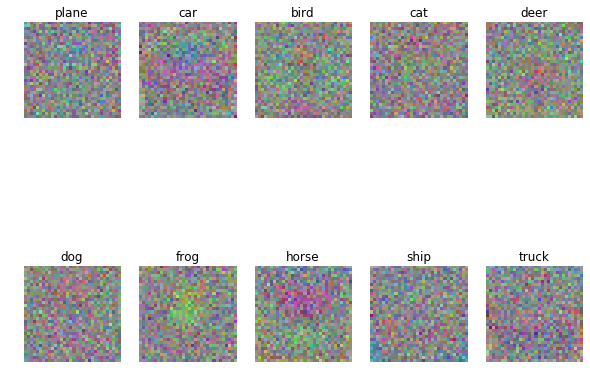

In [8]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])